In [3]:
%load_ext autoreload
%autoreload 2

In [28]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import kelp_compute
import mms

In [20]:
sp.init_printing()
%matplotlib inline

---

## User-function definitions

In [5]:
def uniform_vsf(delta):
    return 1/(4*sp.pi)

In [6]:
# TODO: No upwelling light from bottom
# Also, spatially homogeneous BC
def prod_L(x, y, z, theta, phi, alpha, gamma):
    return (
        (
            (
                (2+sp.sin(2*sp.pi*x/alpha))
                *(2+sp.sin(2*sp.pi*y/alpha))
                *(sp.sin(sp.pi*z/gamma))
            ) + sp.exp(-z/gamma)
        )
        *(2+sp.sin(phi))
    )

In [7]:
def uniform_L(x, y, z, theta, phi, alpha, gamma):
    return alpha

In [8]:
def tanh_L(x, y, z, theta, phi, alpha, gamma):
    return alpha * sp.tanh(gamma-z)

In [9]:
def tanh_b_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha * sp.tanh(gamma-b*z)

In [10]:
# TODO: Should be periodic on correct grid
def prod_a(x, y, z):
    return (2+sp.sin(2*sp.pi*x))*(2+sp.sin(2*sp.pi*y))*(1+sp.tanh(z-gamma))

In [11]:
def uniform_a(x, y, z):
    return 0.2

### Decide here which functions to use.

In [12]:
sol_func = tanh_b_L
abs_func = uniform_a
vsf_func = uniform_vsf

---

## Calculate source & BC

In [16]:
b = sp.var('b')
params = sp.var('b, alpha, gamma')

source_expr = mms.calculate_source(sol_func, b, abs_func, vsf_func, params)
bc_expr = mms.calculate_bc(sol_func, params)

# Evaluate other expressions as well for consistency
sol_expr = sol_func(*mms.space, *mms.angle, *params)
abs_expr = abs_func(*mms.space)
vsf_expr = vsf_func(mms.delta)

## Specify parameter values

In [17]:
alpha = 1
gamma = 1
b = 0.2
param_vals = {
    'alpha': alpha,
    'gamma': gamma,
    'b': b
}

# Domain size
rope_spacing = 1
zmax = 1

## Generate symbolic and numerical functions

In [21]:
# Generate symbolic functions
source_sym = mms.symify(source_expr, *mms.space, *mms.angle, **param_vals)
abs_sym = mms.symify(abs_expr, *mms.space, **param_vals)
bc_sym = mms.symify(bc_expr, *mms.angle, **param_vals)
vsf_sym = mms.symify(vsf_expr, mms.delta, **param_vals)
sol_sym = mms.symify(sol_expr, *mms.space, *mms.angle, **param_vals)

# Generate numerical functions
abs_func_N = kelp_compute.sym_to_num(abs_sym, *mms.space)
source_func_N = kelp_compute.sym_to_num(source_sym, *mms.space, *mms.angle)
bc_func_N = kelp_compute.sym_to_num(bc_sym, *mms.angle)
vsf_func_N = kelp_compute.sym_to_num(vsf_sym, mms.delta)
sol_func_N = kelp_compute.sym_to_num(sol_sym, *mms.space, *mms.angle)

## Problem Summary

In [23]:
print("Solution")
mms.display_eq('L', sol_sym(*mms.space, *mms.angle))
print()

print("Absorption Coefficient")
mms.display_eq('a', abs_sym(*mms.space))
print()

print("VSF")
mms.display_eq('beta', vsf_sym(mms.delta))

print("Boundary Condition")
mms.display_eq('L_0', bc_sym(*mms.angle))
print()

print("Source")
mms.display_eq('sigma', source_sym(*mms.space, *mms.angle))
print()

Solution



Absorption Coefficient



VSF


Boundary Condition



Source


## Check solution constraints

- Everything is periodic in x, y
- Absorption coefficient is positive
- Boundary condition depends only on angle
- No upwelling light from below

## Check source term

Source term seems too high, so try substituting parameters,
then plugging in analytical solution.

The result should be 0.

In [24]:
diff = mms.check_sol(sol_sym, b, abs_sym, vsf_sym, source_sym)
diff

In [26]:
num_diff = sp.lambdify(
    (*mms.space, *mms.angle),
    diff,
    modules=("numpy",)
)

In [32]:
# Check numerical max on grid in case of numerical error in above expression
np.max(num_diff(*mms.gen_grid(10, 10, 10, 1, 1)))

0

## Compare asymptotics to solution expansion

### Compute

In [36]:
# Grid options
ns = 16
nz = 16
na = 10
nomega = na*(na-2) + 2

# Domain size
rope_spacing = 1
zmax = 1

# Solver options
lis_opts = "-i gmres -restart 100 -tol 1e-3"

# Set num_scatters
num_scatters_list = range(5)
max_num_scatters = max(num_scatters_list)

# Norm for error calculations
norm = lambda arr: np.linalg.norm(np.ravel(arr), ord=2)/np.size(arr)

# Numerical function for solution expansion
sol_expansion_N = mms.gen_series_N(sol_expr, max_num_scatters, **param_vals)
# Numerical function for source expansion
source_expansion_N = mms.gen_series_N(source_expr, max_num_scatters, **param_vals)

asymptotic_sol_dict = {}
sol_expansion_dict = {}
asymptotic_err_dict = {}
sol_expansion_err_dict = {}

for num_scatters in num_scatters_list:
    print("n={}".format(num_scatters))
    # Calculate asymptotic solution
    _, asymptotic_results = kelp_compute.solve_rte_with_callbacks_full(
        ns, nz, na,
        rope_spacing, zmax,
        b, abs_sym, source_sym, source_expansion_N, bc_sym, vsf_sym,
        num_scatters=num_scatters, fd_flag=False, lis_opts=lis_opts
    )

    # Extract numerical solutions
    asymptotic_sol = asymptotic_results['rad']
    
    # Store results
    asymptotic_sol_dict[num_scatters] = asymptotic_sol
    
    # Evaluate true solution
    x, y, z, theta, phi = mms.gen_grid(ns, nz, na, rope_spacing, zmax)
    true_sol = sol_func_N(x, y, z, theta, phi)
    
    # Evaluate series expansion
    sol_expansion = np.zeros_like(asymptotic_sol)
    for n in range(num_scatters+1):
        sol_expansion += b**n * sol_expansion_N(x, y, z, theta, phi, n) 
    sol_expansion_dict[num_scatters] = sol_expansion
    
    # Calculate errors
    asymptotic_err = norm(asymptotic_sol-true_sol)
    asymptotic_err_dict[num_scatters] = asymptotic_err
    
    sol_expansion_err = norm(sol_expansion - true_sol)
    sol_expansion_err_dict[num_scatters] = sol_expansion_err

# Evaluate true solution on same grid
true_sol = sol_func_N(x, y, z, theta, phi)

n=0
n=1
n=2
n=3
n=4


In [37]:
# Calculate finite difference solution
_, fd_results = kelp_compute.solve_rte_with_callbacks_full(
    ns, nz, na,
    rope_spacing, zmax,
    b, abs_sym, source_sym, source_expansion_N, bc_sym, vsf_sym,
    num_scatters=0, fd_flag=True, lis_opts=lis_opts
)

fd_sol = fd_results['rad']

fd_err = norm(fd_sol-true_sol)

### Plot

In [42]:
# Pick one angle to evaluate symbolically and plot
l = 0
m = int(np.floor(na/4))

p = mms.p_hat(l, m, na)
th = theta[0,0,0,p]
ph = phi[0,0,0,p]

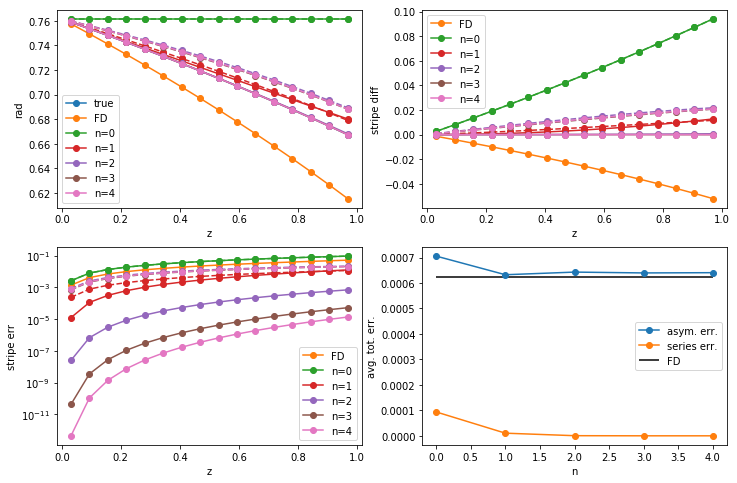

In [43]:
plot_inds = np.zeros_like(true_sol, dtype=bool)
plot_inds[0,0,:,p] = True

plt.figure(figsize=(12,8))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

# Plot true solution
ax1.plot(z[plot_inds], true_sol[plot_inds], 'C0o-', label='true')

# Plot FD solution
ax1.plot(
    z[plot_inds],
    fd_sol[plot_inds], 
    'C1o-',
    label='FD'
)

# Plot FD error
ax2.plot(
    z[plot_inds], 
    -true_sol[plot_inds]+fd_sol[plot_inds], 
    'C1o-',
    label='FD'
)

ax3.plot(
    z[plot_inds], 
    np.abs(-true_sol[plot_inds]+fd_sol[plot_inds]), 
    'C1o-',
    label='FD'
)

for num_scatters in num_scatters_list:
    ax1.plot(
        z[plot_inds], 
        sol_expansion_dict[num_scatters][plot_inds], 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    ax1.plot(
        z[plot_inds], 
        asymptotic_sol_dict[num_scatters][plot_inds], 
        'C{}o--'.format(num_scatters+2)
    )
    
    # Plot true expansion error
    ax2.plot(
        z[plot_inds], 
        -true_sol[plot_inds]+sol_expansion_dict[num_scatters][plot_inds], 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    ax3.plot(
        z[plot_inds], 
        np.abs(-true_sol[plot_inds]+sol_expansion_dict[num_scatters][plot_inds]), 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    
    # Plot numerical asymptotics error
    ax2.plot(
        z[plot_inds], 
        -true_sol[plot_inds]+asymptotic_sol_dict[num_scatters][plot_inds], 
        'C{}o--'.format(num_scatters+2)
    )
    ax3.plot(
        z[plot_inds], 
        np.abs(-true_sol[plot_inds]+asymptotic_sol_dict[num_scatters][plot_inds]), 
        'C{}o--'.format(num_scatters+2)
    )
    
    
ax1.set_xlabel('z')
ax1.set_ylabel('rad')
ax1.legend()

ax2.set_xlabel('z')
ax2.set_ylabel('stripe diff')
ax2.set_yscale('linear')
ax2.legend()

ax3.set_xlabel('z')
ax3.set_ylabel('stripe err')
ax3.set_yscale('log')
ax3.legend()

# FD Error
ax4.hlines(fd_err, xmin=0, xmax=max_num_scatters, label='FD')

# Asymptotics error
ax4.plot(
    num_scatters_list, 
    [asymptotic_err_dict[n] for n in num_scatters_list],
    'o-',
    label='asym. err.'
)
# Expansion error
ax4.plot(
    num_scatters_list, 
    [sol_expansion_err_dict[n] for n in num_scatters_list],
    'o-',
    label='series err.'
)
ax4.set_xlabel('n')
ax4.set_ylabel('avg. tot. err.')
ax4.set_yscale('linear')
ax4.legend()